# The Sequin Cookbook
![sequin](sequin.jpg)

Sequin is meant to make genetic construction design quick and reliable, with a concise and easy-to-remember syntax, and make it easy to track how things were built and what name corresponds to what part. Technically, it is essentially a wrapper for the `pydna` module (Pereira et al., 2015, https://pypi.org/project/pydna/). It also uses `dna_features_viewer` (Zulkower et al., 2020), https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer).

## Installation

Dependencies: you will need the modules `dna_features_viewer` and `pydna` which are available from Pip.

Run `from sequin.record import *` to check that the installation went right. 

## Loading the module

There are two ways to import `sequin`.

One way is to import the `record` class then instanciate an object of that class. This object will store all of our sequences.
This is recommended if the sequin code is part of a larger project using many other functions and modules, as it prevents conflicts if several modules use the same name for a function.
```
from sequin import record
record.pcr(...)
```

The other way is to import the `record` module from sequin directly into the current namespace:
```
from sequin.record import *
pcr(...)
```
This makes the syntax very concise, as you can directly call the functions by their names (e.g. `pcr()`). It is convenient for pure cloning projects when the script is mostly using sequin commands.
This is the mode we will use in this cookbook.

In [1]:
import sys

path_root = '/home/antoine/Code/Sequin' # where you store the source code
sys.path.append(str(path_root))

from sequin.record import *

## Basic idea

### How are sequences represented?

The record class has two class variables that contain DNA sequences: `sequences` and `oligos`.

* `sequences` is a dict containing the DNA sequences such as plasmids, genomes and PCR fragments. Each sequence has a name and associated SeqRecord, DSeqRecord (`pydna`'s double stranded version of a SeqRecord) or plain string.

* `oligos` is a dict that associates oligo's name to their sequence, stored as a string from 5' to 3'. The names can be anything, but it is traditionally something like "your initial" + "oligo number", for example V1, V2, V3...

Most of Sequin's functions refer to sequences by their name. For exemple, to amplify 'pSAMPLE' with oligos 'V1' and 'V2' by PCR the command will simply be:
```
pcr('pSAMPLE', 'V1', 'V2')
```
Here, the function will look for the key "pSAMPLE" in `sequence` and for V1 and V2 in `oligos`.

However, if one of the keys is not found, the functions also accept direct input of a string or SeqRecord object.

### How are positions represented?

A position in the DNA is usually represented by a tuple or list of numbers, corresponding to the beginning and the end of the region of interest. For example, to crop a DNA sequence called 'pSAMPLE' between 100 and 200, we will use:
```
crop('pSAMPLE', [100, 200])
```

### The `name` argument
By default, most functions return a sequence object. However, it's possible to store the result directly in the `sequences` dict by specifying the `name` argument. For example:
```
pcr('pSAMPLE', 'V1', 'V2', name = 'Amplicon')
```
This stores the result of the PCR as `sequences['Amplicon']`, so it can readily be used in other functions.

# Sequin walkthrough
Let's go through examples of the different functions.

## Input and output
Before getting started, let's specify our working folder:

In [2]:
import pathlib

cloning = pathlib.Path('./Samples')

### Importing a collection of oligos
Oligos can be imported in bulk from a CSV file, with the names in first column and the sequences in second column, by default. If your oligo record uses different columns, specify that by setting `name_col` and `seq_col` arguments to the appropriate column numbers.

In [3]:
add_oligos(cloning / 'Oligos.csv')

Found new 78 oligos (0 already present).


### Open sequences in .gb format
Let's import a few GenBank files to play with. This is done with the `add_gb` functions. It returns a pydna's `dseqrecord` object. If the `name` argument is provided, the new sequence will be stored directly into the `sequences` dict.

Sequences are considered to be circular by default, unless the argument `circular` is set to False.

In [4]:
add_gb(cloning / 'pEFLP.gb', name='pEFLP') # plasmid
add_gb(cloning / 'R11.gb', circular=False, name='R11') # synthetic gene
add_gb(cloning / 'pORTMAGE-Ec (addgene 138474).gb', name='pORTMAGE')

## Features

Features are pieces of metadata stored in the genbank files, that give a label and extra information to sections of the sequence. Typically, this would be a label for a gene with its name.

### Cleanup junk features
Many sequences come with annoying features from other software, like ApE's nameless features.
The `clean` method can remove such undesired features. The `junk` argument is a list of feature labels to be removed. Then we will write the cleaned sequences to disk, overwriting the originals.
Sequences can then be exported to GenBank files. If no filename is specified, the key in the `sequences` dict will be used. *No extension should be specified* (it will always be gb).

In [5]:
clean_features('pEFLP')
clean_features('pORTMAGE')

### Write sequences to disk
Then we will write the cleaned sequences to disk, overwriting the originals.
Sequences can then be exported to GenBank files. If no filename is specified, the key in the `sequences` dict will be used. *No extension should be specified* (it will always be gb).

In [6]:
write_gb('pEFLP', folder=cloning)
write_gb('pORTMAGE', folder=cloning, filename='pORTMAGE-Ec (addgene 138474)')

<class 'pydna.dseqrecord.Dseqrecord'>


Samples/pEFLP.gb

<class 'pydna.dseqrecord.Dseqrecord'>


Samples/pORTMAGE-Ec (addgene 138474).gb

### Add new features
There is a function to add a new feature to a sequence. The arguments are, in order, the sequence name, the location, the strand (+1 or -1), the feature's name and the feature's type (CDS, promoter...).

In [7]:
new_feature('pEFLP', (100,200), -1, 'Some new feature', 'terminator')

## Simulating constructions
### Simulating PCR
We can simulate PCRs by giving a template and the name of two oligos. The template can be either a `dseqrecord`, or a `str` in which case the matching sequence will be looked up in the `sequence` dictionary. This will be true in general for most functions using a sequence as input.

The product sequence is returned, unless you specify a `name` argument and then the product will be added to the `sequences` dict under that name.

In [8]:
# pAV203	CspRec-MutL(E32K)	R8+R9	pSC101ts	Amp
pcr('pORTMAGE', 'V1', 'V2', name='R8')
pcr('pEFLP', 'V3', 'V4', name='R9')

R8	pORTMAGE	V1	V2	5076/75.51/69.97
R9	pEFLP	V3	V4	2887/66.42/71.58


In this example, we amplify parts of the pORTMAGE and pEFLP plasmids to create the DNA fragments R8 and R9. These fragments have homology arms, so they can be assembled into a new plasmid by Gibson assembly. Let's simulate this.

### Simulate homologous assembly
To simulate Gibson assembly, use the `assemble` method. As arguments, provide a list of fragment names (or directly provide sequences) and optionally give a name to the product. Here we will tie together the fragments R8 and R9 that we just created.

In [9]:
assemble(['R8','R9'], name='pAV203', verbose=False)
clean_features('pAV203', junk=['AmpR promoter','Amp-R'])
write_gb('pAV203', folder=cloning)

aattacgatttaaatttgtgcactgatagatacaagagc
gggttccgcgcacatttcccgcgcgcccagctgtctagg
//- 5076 bp - [40 bp] -2887 bp - [40 bp] -//
pAV203: 7883 bp circular product.
Removing junk feature "AmpR promoter".
<class 'pydna.contig.Contig'>


Samples/pAV203.gb

### Simulate enzymatic digestion
The `digest` method simulates digestion by restriction enzymes. Specify the enzymes to use as a list. The `fragment` parameter is which fragment you want to keep (as indicated by "(extracted)"). Digested fragments can then be used for assemblies etc. as usual.

In [10]:
add_gb(cloning / 'pIT5-KL (addgene 45984).gb', name='pIT5KL')
digest('pIT5KL', ['EcoRI', 'PstI'], 1, name='R13')

Digestion yields 2 fragments:
0: 1143 bp 
1: 5453 bp (extracted)


## Visualizing sequences

### Display a sequence's map
The `show_map` function can display the map of a circular or linear DNA sequence. 
The visuals are generated by the `DNAfeatureviewer` module from Zulkower et al. 2020.

Let's look at the pAV203 plasmid we just generated.
The `zoom` argument can be used to show only a fraction of the map. Change the plot width with the `width` argument. The map will be circular or linear depending on the sequence, but you can override it with the `topology` argument (set to "circular" or "linear").



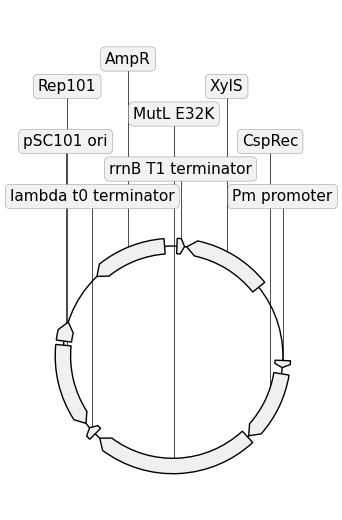

In [11]:
show_map('pAV203', width = 4)

### Overlay the sequence to a part of the map
To show the sequence in a particular spot, use the `zoom` method. The second argument is a couple of coordinates you want to zoom in.

Optionally, the highlight option allows to highlight a region.

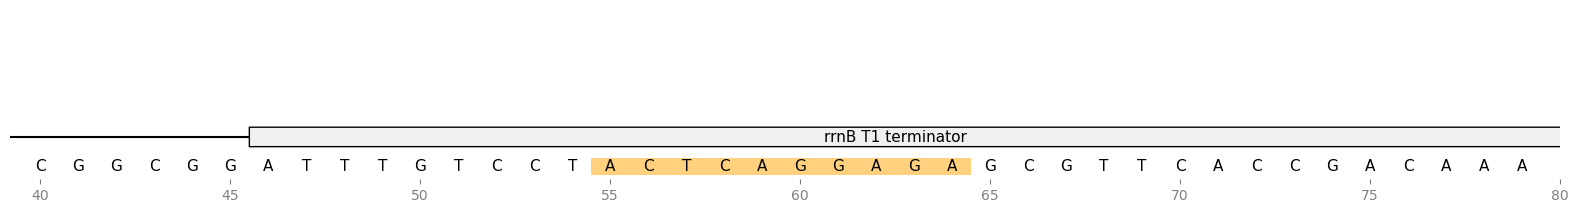

In [12]:
show_sequence('pAV203', (40,80), highlight = (55,65))

### Find existing annealing oligos
To find which primers anneal to a sequence and where, use the `find_primers` method.
Primers that prime from left to right on the map are shown in green, primers that prime from right to left are shown in red.

Template pAV203 7883 nt circular:
V1 anneals forward (--->) at 40
V22 anneals forward (--->) at 2018
V24 anneals forward (--->) at 3019
V26 anneals forward (--->) at 4016
V3 anneals forward (--->) at 5086
V11 anneals forward (--->) at 5088
V12 anneals reverse (<---) at 6303
V27 anneals reverse (<---) at 5082
V2 anneals reverse (<---) at 5022
V25 anneals reverse (<---) at 4082
V23 anneals reverse (<---) at 3079
V4 anneals reverse (<---) at 0

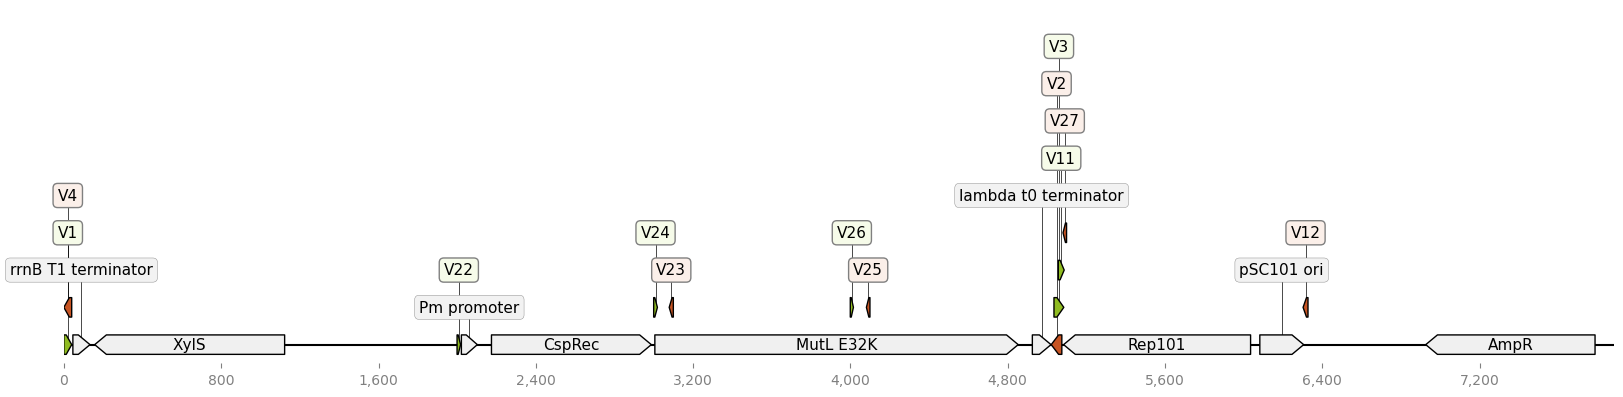

In [13]:
find_primers('pAV203') 

The sequence can be zoomed on by giving a couple of coordinates as the optional `zoom` argument.

The script will look in the `oligos` dict for matching primers, but you can override this with the `oligos_list` argument. For example, we can use the `subset` convenience function to pick the oligos we are interested in.

Template pAV203 7883 nt circular:
V26 anneals forward (--->) at 4016
V2 anneals reverse (<---) at 5022

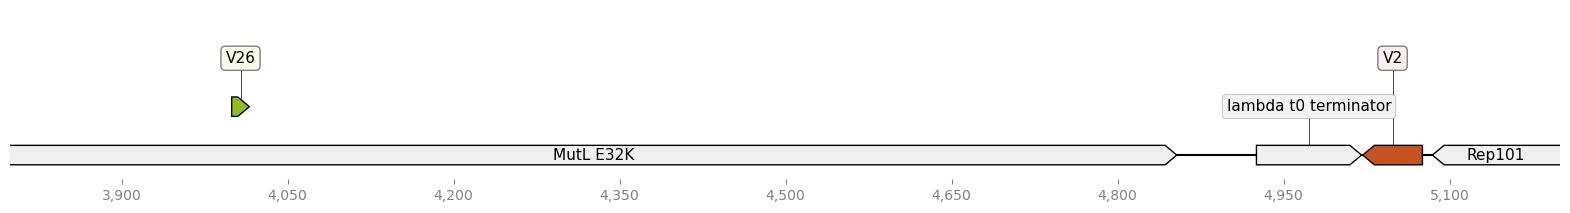

In [14]:
find_primers('pAV203', zoom=(3800,5200), oligos_list = subset(oligos, ['V2', 'V26']))

## Search tools

Instead of entering DNA coordinates manually, it's usually possible to generates the coordinates using search tools.

### Find a feature

To find the coordinates of a particular feature you are interested in, use the `find_features` method. You can also provide a list of features, then the scripts looks for a region that encompasses all the mentioned features.
The `margins` arguments allows you to also include some extra nucleotides on each side of the feature.
The method returns a couple of coordinates.

For example, let's look for the coordinates of the FLP gene, adding 30 bp upstream and 5 bp downstream. Then, we plot this particular region.

FLP: [87:1359](+)


(57, ExactPosition(1364))

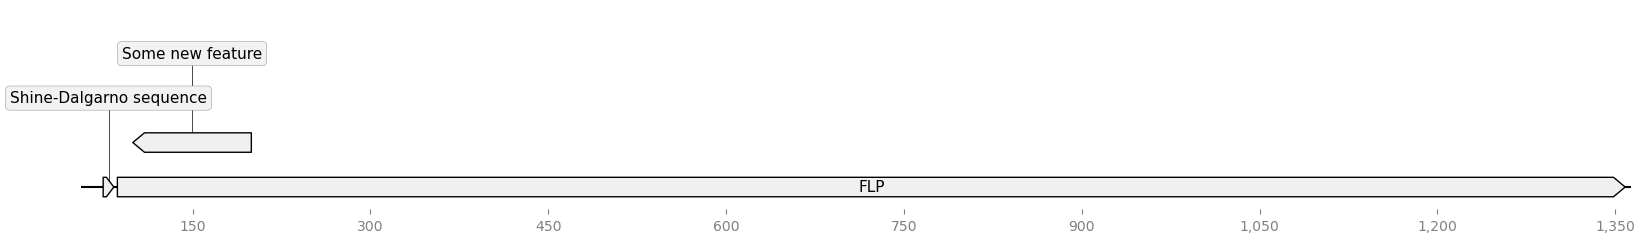

In [15]:
flp_coords = find_features('pEFLP', ['FLP'], margins=(30,5), plot = True)
flp_coords
#show_map('pEFLP', zoom = flp_coords)

Say you want to find the 5' UTR of a gene. You can do something like this:

In [16]:
flp_init = find_features('pEFLP', ['FLP'], margins=(0,0), plot=False)[0] # only keep the first coordinate, i.e. the start of the gene
flp_promoter = (flp_init-80, flp_init) # 80 bp before the gene
flp_init

#show_sequence('pEFLP', flp_promoter, width=10)

FLP: [87:1359](+)


87

### Find a DNA motif
To search for a particular DNA motif, use the `find_motif` method. Degenerate bases (like Ns) are ok. It returns a list of 3-element lists, corresponding to the places where the motif was found.

Each 3-element list contains the starting point, the ending point and the strand. It's possible to search on only one strand using the `strand` argument.

In [17]:
sites = find_motif('pEFLP', 'NGGNGAT') # Both strands
sites_bottom = find_motif('pEFLP', 'NGGNGAT', strand = -1) # Bottom strand only

print(sites)
print(sites_bottom)

[[550, 557, 1], [2522, 2529, 1], [3793, 3800, -1]]
[[3793, 3800, -1]]


### Find ORFs
You can also detect all Open Reading Frames (ORF) on a strand of DNA.
The second argument specifies which strand to search on (+1 or -1). 
The `min_length` argument is optional and is used to exclude the many very short ORFs.

In [18]:
find_orfs('pEFLP', 1, min_length = 500)

[(87, 1359)]

The `find_orfs` function returns a list of coordinates. If there are multiple nested ORFs, set the `greedy` argument to True to only keep the largest.

### Design PCR primers
To design primers to amplify a region within a sequence, use the `make_primers` method. The second parameter is a couple of coordinates that delimits the region to be amplified. The target melting point can be tuned with `tm` and the minimum primer length with `limit`. 

For example, let's make primers that amplify the FLP coding sequence with 10 bp margins.

In [26]:
flp_cds = find_features('pEFLP', ['FLP'], plot = False)

flp_f,flp_r = make_primers('pEFLP', flp_cds, plot = False)

print(flp_f, flp_r)

FLP: [87:1359](+)
ATGCCACAATTTGATATATTATGTAAA TTATATGCGTCTATTTATGTAGGA


If `make_primers` is called with the `names` argument containing the names of the two primers, it will print them in a tab-separated format. This can be copied and pasted to your records or to a DNA ordering service. It also returns a dict containing the two oligos (so you can add it to the oligo dict with `update`).

In [29]:
# Primers to sequence the insert
make_primers('pAV203', (2000,3100), names = ('V21','V22'), plot = False)
make_primers('pAV203', (3000,4100), names = ('V23','V24'), plot = False)
make_primers('pAV203', (4000,5100), names = ('V25','V26'), plot = False)

V21	AGTGTCCGGTTTGATAGG
V22	TCACTAGTTCTTTGACTACCG
V23	ATACACATGCCAATTCAGG
V24	TCTGCAAAGTGATTGCGC
V25	AGCAACTGGAAACGCCGC
V26	TACGGAAGGATCTGAGGTTCTTATGG


{'V25': Seq('AGCAACTGGAAACGCCGC'), 'V26': Seq('TACGGAAGGATCTGAGGTTCTTATGG')}

### Design oligos for homologous assembly
Now we are going to design oligos so that our fragments can be assembled together by Gibson assembly.

First, we make short primers to amplify our fragments.
Then we use the `make_junction` method to add homology tails in 3' of the primers.

Say you want to make junction between PCR fragments A and B, in that order. 
As arguments, put 1) the reverse primer used to amplify A and 2) the forward primer used to amplify B.

This returns two oligos, that correspond to the two oligos provided as arguments with added homology tails. The length of the homology region can be changed with the `homology` argument.

In [34]:
flp_f, flp_r = make_primers('pEFLP', (100,500), plot=False)
pit5_f, pit5_r = make_primers('pORTMAGE', (2000,2500), plot=False)

flp_r_j, pit5_f_j = make_junction(flp_r, pit5_f) # Add an homology tail to pit5_f, corresponding to the reverse primer of fpl

print(pit5_f)
print(pit5_f_j)

Junction:
5' tatgccgagcgcatgaagCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCgataaagggaatagacgaagaa 5'
CTTCATGCGCTCGGCATA
aagaagcagataagggaaatagCTTCATGCGCTCGGCATA


It's also possible to introduce a linker between the two fragments to be assembled. Just specify the sequence of the "top" strand of the linker.

In [35]:
make_junction(flp_r, pit5_f, linker='AAAGGGCCCTTT')

Junction:
5'       gagcgcatgaagaaagggccctttCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCtttcccgggaaagataaagggaatagac       5'


(Seq('gagcgcatgaagaaagggccctttCTATTTCCCTTATCTGCTTCTT'),
 Seq('cagataagggaaatagaaagggccctttCTTCATGCGCTCGGCATA'))

### Assign new names to new oligos

This is assuming you are using a [initial][number] naming convention for your oligos.

To find the latest (not used yet) oligo name, use the `latest` method with the prefix of your choice.

The `new_oligos` method takes a list/tuple of oligos and a prefix as input, and adds the oligos to the main oligo dict with adequate numbering. If a sequence is already in the dict, it will be skipped.

Then, the new oligos are printed in a copy-pastable format.

In [36]:
new_oligos(make_primers('pAV203', (4000,5100), plot = False), prefix = 'V')


Name	Sequence
V79	AGCAACTGGAAACGCCGC
V80	TACGGAAGGATCTGAGGTTCTTATGG


{'V79': Seq('AGCAACTGGAAACGCCGC'), 'V80': Seq('TACGGAAGGATCTGAGGTTCTTATGG')}

Note that **Sequin will never modify your oligo record file**. To add these new oligos to your records, you can copy and paste the lines above at the end of your oligo table (here `Samples/Oligos.csv`). Then, next time you use `add_oligos`, the newest oligos will be included.

This is to avoid possible confusion due to overwriting.

# Random examples

In [39]:
# Find an oligo with a tm of 63°C within a region

target = [2700, 3000]

score = 5
best_oligo = ''

for i in range(target[0],target[1]):
    oligo = sequences['pEFLP'][i:i+20].seq.watson
    new_score = abs(tm(oligo) - 63)
    if new_score <= score:
        print(score)
        score = new_score
        best_oligo = oligo
        
print(best_oligo, tm(best_oligo), score)

5
4.850000000000001
1.8900000000000006
0.8200000000000003
0.04999999999999716
0.030000000000001137
GCAGTGAATGGGGGTAAATG 63.03 0.030000000000001137


In [50]:
# Generate several versions of Gibson assembly junctions, each with a different linker

linkers = ['GTGTGGTGTATCTTACCGGC', 'ATTCGTGAATTGTCGTGGTT', 'CGTGGCACACGCGGTCCCTC', 'TATGTCTTACGGGTATGGT', 'CCAAGGTACGCCGGCTTTGT']

new = []

for linker in linkers:
    jr, jf = make_junction(flp_r, pit5_f, linker = linker)
    new.append(jf)
    new.append(jr)

new_oligos(new, prefix = 'V')

Junction:
5'           gcatgaaggtgtggtgtatcttaccggcCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCcacaccacatagaatggccggataaagggaat           5'
Junction:
5'           gcatgaagattcgtgaattgtcgtggttCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCtaagcacttaacagcaccaagataaagggaat           5'
Junction:
5'           gcatgaagcgtggcacacgcggtccctcCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCgcaccgtgtgcgccagggaggataaagggaat           5'
Junction:
5'           gcatgaagtatgtcttacgggtatggtCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCatacagaatgcccataccagataaagggaat           5'
Junction:
5'           gcatgaagccaaggtacgccggctttgtCTATTTCCCTTATCTGCTTCTT 3'
3' ATACGGCTCGCGTACTTCggttccatgcggccgaaacagataaagggaat           5'

Name	Sequence
V81	taagggaaataggccggtaagatacaccacacCTTCATGCGCTCGGCATA
V82	gcatgaaggtgtggtgtatcttaccggcCTATTTCCCTTATCTGCTTCTT
V83	taagggaaatagaaccacgacaattcacgaatCTTCATGCGCTCGGCATA
V84	gcatgaagattcgtgaattgtcgtggttCTATTTCCCTTATCTGCTTCTT
V85	taagggaaataggagggaccgcgtgtgccacgCTTCATGCGCT

{'V81': Seq('taagggaaataggccggtaagatacaccacacCTTCATGCGCTCGGCATA'),
 'V82': Seq('gcatgaaggtgtggtgtatcttaccggcCTATTTCCCTTATCTGCTTCTT'),
 'V83': Seq('taagggaaatagaaccacgacaattcacgaatCTTCATGCGCTCGGCATA'),
 'V84': Seq('gcatgaagattcgtgaattgtcgtggttCTATTTCCCTTATCTGCTTCTT'),
 'V85': Seq('taagggaaataggagggaccgcgtgtgccacgCTTCATGCGCTCGGCATA'),
 'V86': Seq('gcatgaagcgtggcacacgcggtccctcCTATTTCCCTTATCTGCTTCTT'),
 'V87': Seq('taagggaaatagaccatacccgtaagacataCTTCATGCGCTCGGCATA'),
 'V88': Seq('gcatgaagtatgtcttacgggtatggtCTATTTCCCTTATCTGCTTCTT'),
 'V89': Seq('taagggaaatagacaaagccggcgtaccttggCTTCATGCGCTCGGCATA'),
 'V90': Seq('gcatgaagccaaggtacgccggctttgtCTATTTCCCTTATCTGCTTCTT')}